PyTorchによるLSTMの実装
http://aidiary.hatenablog.com/entry/20180827/1535373373


In [1]:

from random import randint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')
device = torch.device('cuda' if cuda else 'cpu')

In [2]:
def generate_sequence(length, n_features):
    """長さがlengthで、ランダムな整数がn_featuresまでの系列を1つ生成する"""
    return [randint(0, n_features - 1) for _ in range(length)]

In [3]:
def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [4]:
def generate_example(length, n_features, out_index):
    sequence = generate_sequence(length, n_features)
    encoded = one_hot_encode(sequence, n_features)
    
    # ndarray => tensor
    # PyTorchでは入力はfloatにする必要あり
    encoded = torch.from_numpy(encoded).float()
    
    # LSTMへの入力は3Dテンソル (seq_len, batch, input_size)
    X = encoded.view(length, 1, n_features)

    # out_index番目の入力を出力するようにする
    # PyTorchは出力はone-hotではなくラベルそのものを返す
    y = torch.Tensor([sequence[out_index]]).long()

    return X, y

% generate_example(5, 10, 2)
(tensor([[[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],
 
         [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]), tensor([ 5]))

In [5]:
# model
length = 5
n_features = 10
hidden_size = 25
out_index = 2

class EchoSequencePredictionModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, target_size):
        super(EchoSequencePredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, target_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, h, c):
        output, (h, c) = self.lstm(input, (h, c))
        output = self.out(output)
        output = self.softmax(output)
        return output, (h, c)

    def init_hidden(self):
        # (num_layers, batch, hidden_size)
        h = torch.zeros(1, 1, self.hidden_size).to(device)
        c = torch.zeros(1, 1, self.hidden_size).to(device)
        return h, c

model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
print(model)

EchoSequencePredictionModel(
  (lstm): LSTM(10, 25)
  (out): Linear(in_features=25, out_features=10, bias=True)
  (softmax): LogSoftmax()
)


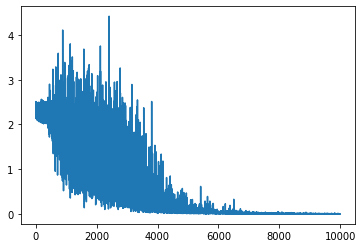

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

# training
for i in range(10000):
    # 系列データを1つ生成
    X, y = generate_example(length, n_features, out_index)

    # 系列を1つ入力してパラメータ更新したら勾配はリセット
    model.zero_grad()
    
    # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
    # LSTMのパラメータは更新されたまま残る
    h0, c0 = model.init_hidden()

    # 系列を入力して出力系列を求める
    # output: (seq_len, batch, hidden_size)
    output, (h, c) = model(X, h0, c0)

    # many-to-oneのタスクなので出力系列の最後の要素のみ使う
    loss = criterion(output[-1], y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

plt.plot(losses)
plt.show()

In [11]:
X, y = generate_example(length, n_features, out_index)
h0, c0 = model.init_hidden()
yhat = model(X, h0, c0)


print('input sequence:', [one_hot_decode(x) for x in X])
print('expected:', y)
print('predicted:', torch.argmax(yhat[0][-1]))

input sequence: [[tensor(4)], [tensor(3)], [tensor(5)], [tensor(0)], [tensor(9)], [tensor(4)], [tensor(7)], [tensor(6)], [tensor(8)], [tensor(5)]]
expected: tensor([5])
predicted: tensor(5)


入力系列が [5, 0, 4, 8, 7] のとき、2番目を出力するモデルなので4が正解、予測も4なので合っています。

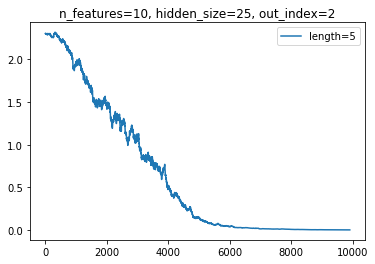

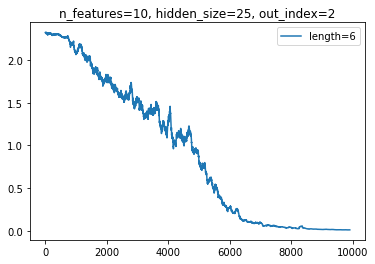

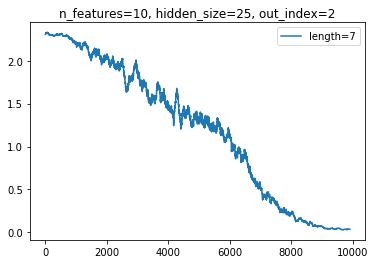

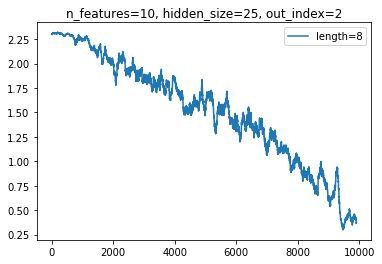

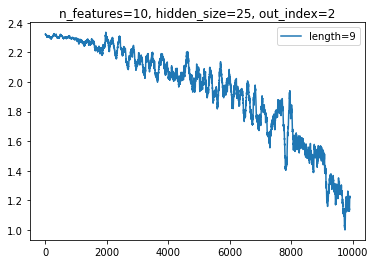

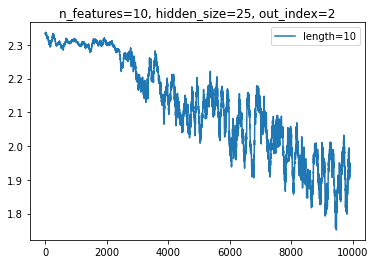

In [8]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

# model
n_features = 10
hidden_size = 25
out_index = 2

for length in range(5, 11):
    model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    # training
    for i in range(10000):
        # 系列データを1つ生成
        X, y = generate_example(length, n_features, out_index)

        # 系列を1つ入力してパラメータ更新したら勾配はリセット
        model.zero_grad()

        # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
        # LSTMのパラメータは更新されたまま残る
        h0, c0 = model.init_hidden()

        # 系列を入力して出力系列を求める
        # output: (seq_len, batch, hidden_size)
        output, (h, c) = model(X, h0, c0)

        # many-to-oneのタスクなので出力系列の最後の要素のみ使う
        loss = criterion(output[-1], y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    losses = moving_average(losses, 100)
    plt.title('n_features=%d, hidden_size=%d, out_index=%d' % (n_features, hidden_size, out_index))
    plt.plot(losses, label='length=%d' % length)
    plt.legend()
    plt.show()